<img src="https://www.iscte-iul.pt/assets/images/logo_iscte_detailed.svg" style="width: 450px;margin-top:30px;" align ="center">

<div style= "font-size: 40px;  margin-top:40px; font-weight:bold; font-family: 'Avenir Next LT Pro', sans-serif;"><center>Challenge 2 - Part 2: <strong>Custom CNN</strong></center></div>
<div style= "font-size: 40px; font-weight:bold; font-family: 'Avenir Next LT Pro', sans-serif;"><center>for cats_and_dogs dataset using neural networks</center></div>

<div style= "font-size: 27px;font-weight:bold;line-height: 1.1; margin-top:40px; font-family: 'Avenir Next LT Pro', sans-serif;"><center>Aprendizagem Profunda para Visão por Computador 2024/2025</center></div> <br>

   <div style= "font-size: 20px;font-weight:bold; font-family: 'Avenir Next LT Pro', sans-serif;"><center> Grupo 7:</center></div>
   <div><center> Diogo Freitas | 104841 </center></div>
   <div><center> João Francisco Botas | 104782 </center></div>
   <div><center> Miguel Gonçalves | 105944 </center></div>
   <div><center> Ricardo Galvão | 105285 </center></div>

<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <style>
        body {
            font-family: Arial, sans-serif;
            background-color: #f4f4f4;
            color: #333;
            margin: 0;
            padding: 20px;
            line-height: 1.6;
        }
        ol {
            counter-reset: section;
            list-style: none;
            padding-left: 0;
        }
        /* First-level list */
        ol > li {
            counter-increment: section;
            margin-bottom: 10px;
            padding-left: 0;
        }
        ol > li::before {
            content: counters(section, ".") " ";
            font-weight: bold;
        }
        /* Second-level list */
        ol ol {
            counter-reset: subsection;
            padding-left: 20px;
            margin-top: 5px;
        }
        ol ol > li {
            counter-increment: subsection;
            margin-bottom: 5px;
            padding-left: 10px;
        }
        ol ol > li::before {
            content: counters(section, ".") "." counter(subsection) " ";
            font-weight: bold;
        }
        /* Third-level list */
        ol ol ol {
            counter-reset: subsubsection;
            padding-left: 40px;
            margin-top: 5px;
        }
        ol ol ol > li {
            counter-increment: subsubsection;
            margin-bottom: 5px;
            padding-left: 10px;
            font-size: 0.9em; /* Make font size smaller */
            font-weight: normal; /* Remove bold styling */
        }
        ol ol ol > li::before {
            content: counters(section, ".") "." counter(subsection) "." counter(subsubsection) " ";
            font-weight: bold;
        }
        a {
            text-decoration: none;
            color: #007BFF;
            font-weight: bold;
        }
        a:hover {
            color: #0056b3;
        }
        footer {
            margin-top: 50px;
        }
    </style>
</head>
<body>

<h2><b>Índice</b></h2>
<ol>
    <li><a href="#1">Objetivo desta parte</a></li>
    <li><a href="#2">Setup para desenvolvimento do projeto</a></li>
            <ol>
            <li><a href="#2.1">Obter um conjunto de validação</a></li>
        </ol>
    <li><a href="#3">Rede neuronal convolucional “custom”</a></li>
        <ol>
            <li><a href="#3.1">Construir o modelo</a></li>
            <li><a href="#3.2">Compilar a rede</a></li>
            <li><a href="#3.3">Treinar o modelo – max 50 épocas, de pref. a usar callbacks</a></li>
            <li><a href="#3.4">Gráfico que mostre a evolução do treino</a></li>
            <li><a href="#3.5">Cálculo dos acertos no conjunto de teste</a></li>
            <li><a href="#3.6">Mostrar a matriz de confusão</a></li>
        </ol>
    <li><a href="#4">Model Explanation</a></li>
</ol>

<footer></footer>

</body>
</html>

# <a class='anchor' id='1'></a>

> # **1. Objetivo desta parte** 

Dizer os objetivos

# <a class='anchor' id='2'></a>

> # **2. Setup para desenvolvimento do projeto**

In [1]:
import tensorflow as tf
import keras
from keras import layers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import cv2

import seaborn as sns
import sys
import os
from pathlib import Path

import nbformat
from nbconvert import PythonExporter

from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from tf_keras_vis.utils.scores import CategoricalScore

from tensorflow.keras.models import Model 

In [2]:
# Configurar a seed do TensorFlow
tf.keras.utils.set_random_seed(42)
# Definir a seed global para a operação de GPU
tf.config.experimental.enable_op_determinism()


# Definir o número de threads
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Para evitar log excessivo de TensorFlow
os.environ['OMP_NUM_THREADS'] = '1'  # Para limitar o número de threads

# <a class='anchor' id='2.1.'></a>

> # **2.1. Criação de um conjunto de Validação**

In [3]:
%run ../src/cats_and_dogs.py

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Using 500 files for training.
Using 500 files for validation.
Train: 2000 samples, 50.00% dogs
Validation: 500 samples, 49.40% dogs
Test: 500 samples, 50.60% dogs


# <a class='anchor' id='3'></a>

> # **3. Rede neuronal convolucional “custom”**

# <a class='anchor' id='3.1'></a>

> ## **a) Construir o modelo**

In [4]:
# Baseline model
baseline_model = keras.Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 5, padding='same', activation='relu'),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=4),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation="sigmoid")
])

# Model with more Conv2D layers
conv2d_model = keras.Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 5, padding='same', activation='relu'),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=4),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation="sigmoid")
])

# Model with dropout and more Conv2D layers
dropout_model = keras.Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 5, padding='same', activation='relu'),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=4),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation="sigmoid")
])

# Model with dropout, more Conv2D layers and data augmentation

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),  # Espelhamento horizontal
    layers.RandomRotation(0.1),  # Rotação até ±10%
    layers.RandomZoom(0.1),  # Zoom in/out até ±10%
    layers.RandomContrast(0.1),  # Ajuste de contraste
    layers.RandomBrightness(0.1),  # Ajuste de brilho
])

final_model = keras.Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    data_augmentation,
    layers.Conv2D(16, 5, padding='same', activation='relu'),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=4),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation="sigmoid")
])

In [5]:
ModelosEscolhidos = [baseline_model, conv2d_model, dropout_model, final_model]
model = ModelosEscolhidos[3]

ModelosEscolhidos = {
    baseline_model: 'baseline_model',
    conv2d_model: 'conv2d_model',
    dropout_model: 'dropout_model',
    final_model: 'final_model'
}

# <a class='anchor' id='3.2'></a>

> ## **b) Compilar a rede**

In [6]:
# Callback para guardar os pesos do melhor modelo
best_model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=f"tmp/{ModelosEscolhidos[model]}.weights.h5",  # Caminho onde os pesos do melhor modelo serão guardados
    save_weights_only=True,  # Apenas os pesos do modelo são guardados (não a arquitetura completa)
    monitor='val_loss',  # Monitoriza a perda (loss) no conjunto de validação
    mode='min',  # O melhor modelo será aquele que tiver a menor val_loss
    save_best_only=True  # Apenas guarda o modelo se for o melhor encontrado até ao momento
)

# Callback para interromper o treino cedo caso a perda não melhore
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitoriza a perda no conjunto de validação
    patience=5  # Se a val_loss não melhorar durante 5 epochs consecutivas, o treino é interrompido
)

# Callback para reduzir a taxa de aprendizagem quando a perda estabiliza
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # Monitoriza a perda no conjunto de validação
    factor=0.5,  # Reduz a taxa de aprendizagem para 50% do valor atual
    patience=7,  # Aguarda 7 epochs sem melhoria antes de reduzir a taxa de aprendizagem
    min_lr=1e-6  # Define um limite mínimo para a taxa de aprendizagem (não reduz mais do que isto)
)

In [7]:
# Compilar o modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# <a class='anchor' id='3.3'></a>

> ## **c) Treinar o modelo – max 50 épocas, de pref. a usar callbacks**


In [8]:
# Treinar o modelo (máx. 50 épocas, usando callbacks)
history = model.fit(train, epochs=50, 
                    validation_data=validation,
                    callbacks=[best_model_checkpoint, early_stopping, reduce_lr])

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 64s 963ms/step - accuracy: 0.5195 - loss: 50.4923 - precision: 0.5242 - recall: 0.4873 - val_accuracy: 0.5860 - val_loss: 0.6782 - val_precision: 0.5488 - val_recall: 0.9109 - learning_rate: 0.0010
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 62s 989ms/step - accuracy: 0.6109 - loss: 0.6660 - precision: 0.5943 - recall: 0.7072 - val_accuracy: 0.6460 - val_loss: 0.6371 - val_precision: 0.6023 - val_recall: 0.8340 - learning_rate: 0.0010
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 61s 969ms/step - accuracy: 0.6452 - loss: 0.6491 - precision: 0.6570 - recall: 0.6128 - val_accuracy: 0.6440 - val_loss: 0.6282 - val_precision: 0.6068 - val_recall: 0.7935 - learning_rate: 0.0010
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 57s 901ms/step - accuracy: 0.6590 - loss: 0.6343 - precision: 0.6687 - recall: 0.6358 - val_accuracy: 0.6780 - val_loss: 0.6028 - val_precision: 0.6405 - val_recall: 0.7935 - learning_rate: 0.0010
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 57s 901ms/step - accu

# <a class='anchor' id='3.4'></a>

> ## **d) Gráfico que mostre a evolução do treino**

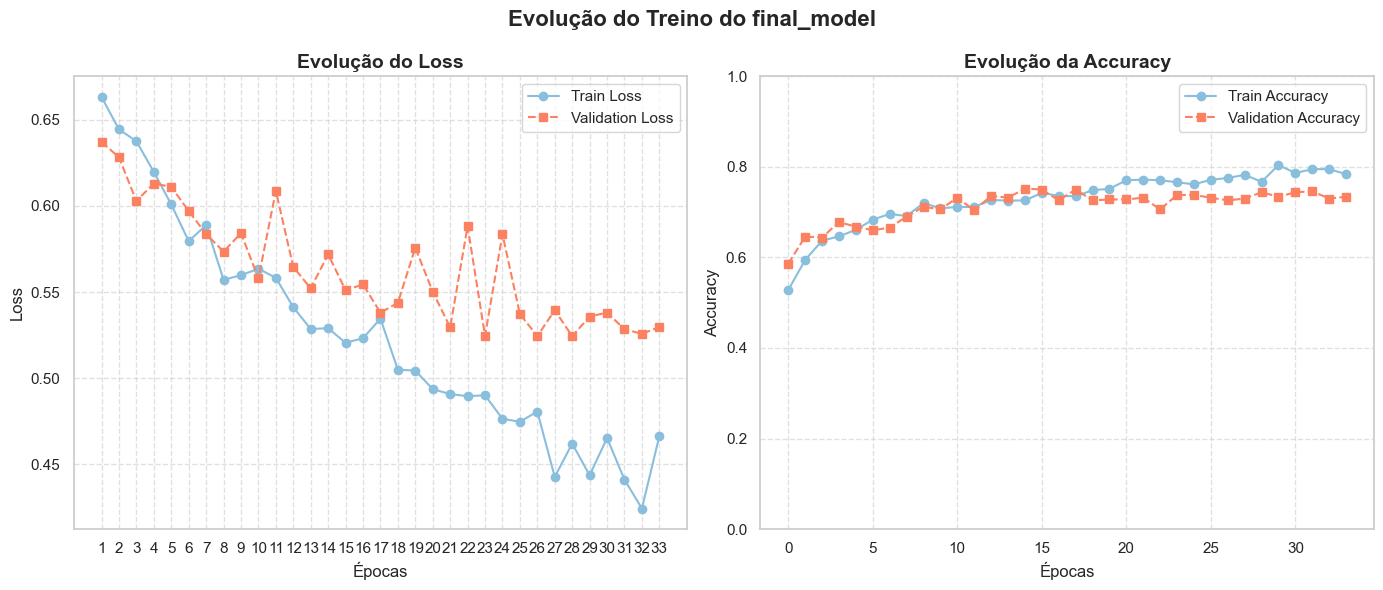

In [9]:
# Configurar o estilo do seaborn
sns.set(style="whitegrid", palette="muted")

# Criar a figura
plt.figure(figsize=(14, 6))

# Subplot para Loss
plt.subplot(1, 2, 1)
epochs = range(1, len(history.history['loss']))  # Garante que começa em 1
plt.plot(epochs, history.history['loss'][1:], label='Train Loss', color=sns.color_palette("Blues")[2], linestyle='-', marker='o', markersize=6)
plt.plot(epochs, history.history['val_loss'][1:], label='Validation Loss', color=sns.color_palette("Reds")[2], linestyle='--', marker='s', markersize=6)
plt.xlabel('Épocas', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Evolução do Loss', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Definir os ticks do eixo X para começar em 1
plt.xticks(epochs)


# Subplot para Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color=sns.color_palette("Blues")[2], linestyle='-', marker='o', markersize=6)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color=sns.color_palette("Reds")[2], linestyle='--', marker='s', markersize=6)
plt.xlabel('Épocas', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Evolução da Accuracy', fontsize=14, fontweight='bold')
plt.ylim(0, 1)  # Garantir que o eixo Y da Accuracy vai de 0 a 1
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Adicionar um título geral à figura
plt.suptitle(f'Evolução do Treino do {ModelosEscolhidos[model]}', fontsize=16, fontweight='bold')

# Ajustar espaçamento
plt.tight_layout()
plt.show()

In [11]:
# Carregar melhor modelo em validação
model.load_weights(f"tmp/{ModelosEscolhidos[model]}.weights.h5")
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 256, 256, 16)        │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 256, 256, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │      16,777,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,627,045 (193.13 MB)

 Trainable params: 16,875,681 (64.38 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 33,751,364 (128.75 MB)

# <a class='anchor' id='3.5'></a>

> ## **e) Cálculo dos acertos no conjunto de teste**

In [12]:
train_list = list(train)
first_batch_x, first_batch_y = train_list[0]
len(train_labels)

2000

In [13]:
# Avaliação no conjunto de teste
test_loss, test_acc = model.evaluate(test, verbose=0)[:2]
num_acertos = int(test_acc * len(test_labels))
print(f'Accuracy no conjunto de teste: {test_acc:.4f}')
print(f'Número absoluto de acertos: {num_acertos}/{len(test_labels)}')

Accuracy no conjunto de teste: 0.7460
Número absoluto de acertos: 372/500


# <a class='anchor' id='3.6'></a>

> ## **f) Mostrar a matriz de confusão**

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step


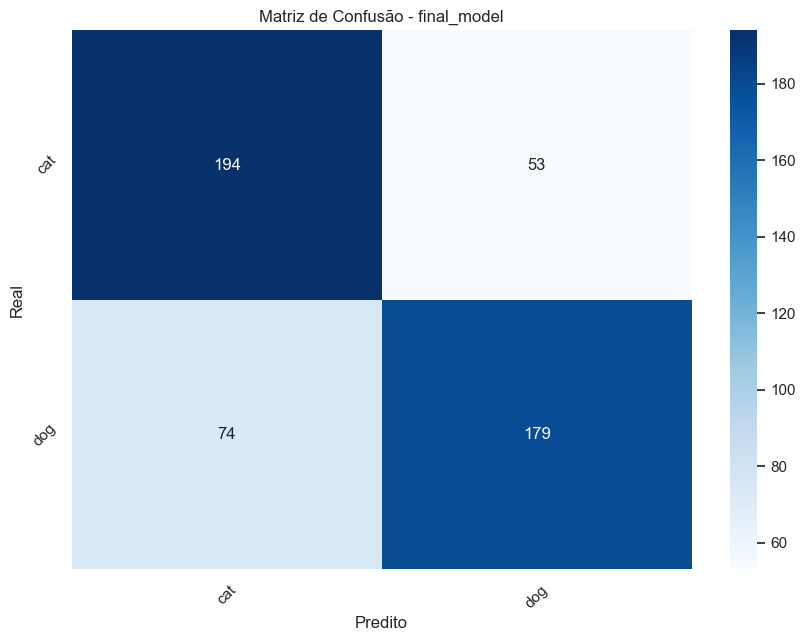

In [14]:
# Predições e matriz de confusão
y_pred = model.predict(test)
y_pred_classes = y_pred.squeeze()>0.5
y_true_classes = test_labels.squeeze()

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title(f'Matriz de Confusão - {ModelosEscolhidos[model]}')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [15]:
# Relatório de classificação
print("Relatório de Classificação:")
print(classification_report(y_true_classes, y_pred_classes, target_names=labels))

Relatório de Classificação:
              precision    recall  f1-score   support

         cat       0.72      0.79      0.75       247
         dog       0.77      0.71      0.74       253

    accuracy                           0.75       500
   macro avg       0.75      0.75      0.75       500
weighted avg       0.75      0.75      0.75       500



# <a class='anchor' id='5'></a>

> # **4. Model Explanation**

In [16]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 256, 256, 16)        │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 256, 256, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │      16,777,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,627,045 (193.13 MB)

 Trainable params: 16,875,681 (64.38 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 33,751,364 (128.75 MB)

In [17]:
linear_model = tf.keras.models.Model(inputs=[model.layers[0].input], outputs=[model.layers[-2].output])
train_preds = model.predict(train).squeeze()
labels

63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step


['cat', 'dog']

In [18]:
train_list = list(train)
score = CategoricalScore([0])
saliency = Saliency(model, clone=False)

C:\Users\Avey\miniforge3\envs\apvc\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_30
Received: inputs=['Tensor(shape=(1, 256, 256, 3))']
  warnings.warn(msg)


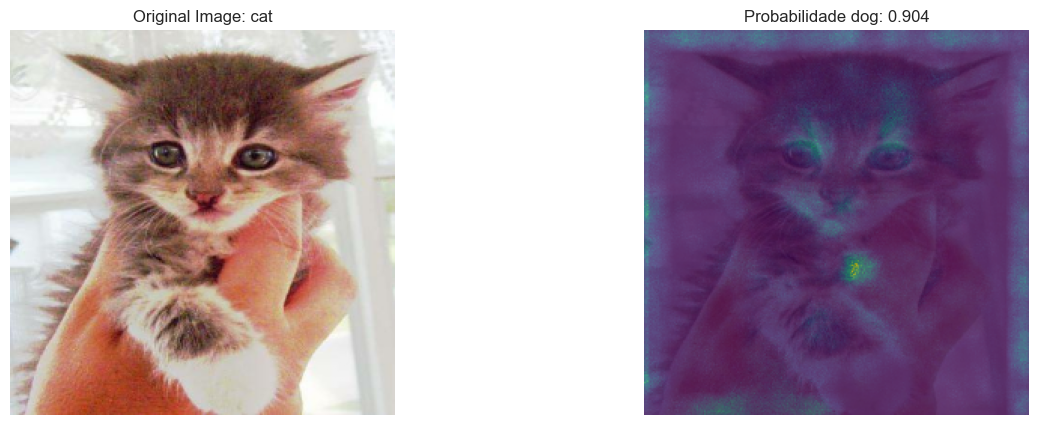

In [19]:
# Load and preprocess an example image
img_id = 0 # 5656
img = train_list[0][0][img_id]  # Tensor
img_array = np.expand_dims(img, axis = 0)  # Normalize and add batch dimension, now numpy array
# Compute saliency map
saliency_map = saliency(score, img_array, smooth_samples=20, smooth_noise=0.2)
saliency_map = normalize(saliency_map)
# Overlay saliency map on original image
heatmap = cv2.cvtColor(cv2.applyColorMap(np.uint8(np.floor(saliency_map*255)).squeeze(), cv2.COLORMAP_VIRIDIS), cv2.COLOR_BGR2RGB)
overlay = cv2.addWeighted(heatmap, 0.7, np.uint8(img), 0.2, 0)

# Display results
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(img/255)
ax[0].set_title(f"Original Image: {labels[int(train_list[0][1][img_id])]}")
ax[0].axis("off")

ax[1].imshow(overlay)
ax[1].set_title(f"Probabilidade {labels[1]}: {train_preds[img_id]:.3f}")
ax[1].axis("off")

plt.show()

In [20]:
# https://tree.rocks/get-heatmap-from-cnn-convolution-neural-network-aka-grad-cam-222e08f57a34